# Trying PC Algorithm

# Overview

To understand the PC Algorithm, analyzing relationships between features using a dataset from the UCI Machine Learning Repository.

Via conditional independence tests, progressively removes independent feature connections, in line with the PC Algorithm's approach.

 - [A survey of Bayesian Network structure learning](https://link.springer.com/article/10.1007/s10462-022-10351-w)

 - [An Algorithm for Fast Recovery of Sparse Causal Graphs](https://journals.sagepub.com/doi/abs/10.1177/089443939100900106)

 - [Renovamen/pcalg-py](https://github.com/Renovamen/pcalg-py)
 
 - [huawei-noah/trustworthyAI](https://github.com/huawei-noah/trustworthyAI)


## About PC Algorithm

Quote from "A survey of Bayesian Network structure learning - 3.2.2 The PC algorithm" :

> In the SGS algorithm, the adjacency phase tests "all possible conditioning sets for each pair of nodes", which is computationally expensive and involves many unreliable high-order Conditional Independence tests.
> 
> To address this, Spirtes and Glymour introduced the PC algorithm in 1991, which uses "incrementally" larger conditioning sets during the adjacency phase and "only considers nodes adjacent to each other".
> 
> Initially ineffective as PC starts with a complete graph, this method becomes beneficial by reducing the number and order of CI tests as edges are removed.

## PC Algorithm

In the original paper, the PC algorithm is described as follows:

 - Let $Aab$ denote the set of "vertices adjacent" to $a$ or to $b$.

 - Let $Pab$ denote the set of vertices that are "parents" of $a$ or of $b$.

 - Let $Uab$ denote the set of vertices on "undirected paths" between $a$ and $b$.
    
 (A) Form the complete graph $C_{-1}$ on the vertex set $V$.

 (B) For each pair of variables $a, b$ adjacent in $C_n$:

 (B-a) If $Aab \cap Uab$ does not have cardinality greater than $n$, go to the next pair of vertices adjacent in $C_n$.

 (B-b) If $Aab$ has does have cardinality greater than $n$, determine if $a, b$ are independent conditional on any subsets of $Aab \cap Uab$ of cardinality $n+1$. If so, delete $a-b$ from $C_n$.

Let $C_{n+1}$ be the graph that results from this procedure applied to each pair of variables.

Continue until a value $f+1$ of $n$ is reached such that $B$ is not satisfied for any pair.

 (C) For each triple of vertices $a, b, c$ such that the pair $a, b$ and the pair $b, c$ are each adjacent in $C_f$ but the pair $a, c$ are not adjacent in $C_f$, orient $a - b - c$ as $a \rightarrow b \leftarrow c$ if and only if $a$ and $c$ are dependent on every subset of $Aac \cap Uac$ containing $b$.

Output all graphs consistent with these orientations.

In [23]:
import numpy as np
import pandas as pd
import math
from itertools import combinations, permutations
from scipy import stats
from ucimlrepo import fetch_ucirepo
import networkx as nx

# Load Data from UCI Repository

 - [uci-ml-repo/ucimlrepo](https://github.com/uci-ml-repo/ucimlrepo)

 - [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

In [2]:
data = fetch_ucirepo(id=17).data.features 
data["diagnosis"] = (fetch_ucirepo(id=17).data.targets == "M").astype(int)
data

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [3]:
label = data.columns.tolist()
data = data.to_numpy()

Create "Complete Graph" with "nodes"

```
# other method (1)
graph = np.ones((nodes, nodes), dtype = bool)
np.fill_diagonal(graph, 0)
```

```
# other method (2)
[[i != j for i in range(features)] for j in range(features)]
```

In [4]:
nodes = data.shape[1]

In [5]:
graph = np.ones((nodes, nodes)) - np.eye(nodes)

Plot the Complete Graph

In [6]:
def plot_graph(g, n, l):
    network = nx.from_numpy_array(g)
    nx.draw(network,
            edge_color = "gray",
            width = 1,
            linewidths = 1,
            node_size = 500,
            node_color = "pink",
            alpha=0.9,
            labels = dict(zip(range(n), l)))

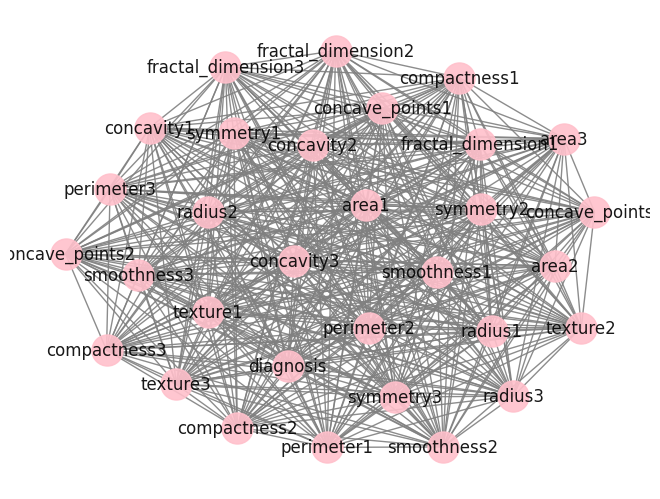

In [7]:
plot_graph(graph, nodes, label)

Create a list to store all posibile pairs of nodes

In [8]:
pairs = [*combinations(range(nodes), 2)]

the is_independent function were directly copy "fisherz_test" function from [gcastle/castle/common/independence_tests.py](https://github.com/huawei-noah/trustworthyAI/blob/master/gcastle/castle/common/independence_tests.py)

the only chage was output, from `return p_value` to `return (p_value >= 0.05)`

In [9]:
def is_independent(data, x, y, z):
    
    n = data.shape[0]
    k = len(z)
    
    if k == 0:
        r = np.corrcoef(data[:, [x, y]].T)[0][1]
        
    else:
        sub_index = [x, y]
        sub_index.extend(z)
        sub_corr = np.corrcoef(data[:, sub_index].T)
        
        try:
            PM = np.linalg.inv(sub_corr)
            
        except np.linalg.LinAlgError:
            PM = np.linalg.pinv(sub_corr)
            
        r = -1 * PM[0, 1] / math.sqrt(abs(PM[0, 0] * PM[1, 1]))
        
    cut_at = 0.99999
    
    r = min(cut_at, max(-1 * cut_at, r))

    res = math.sqrt(n - k - 3) * .5 * math.log1p((2 * r) / (1 - r))
    p_value = 2 * (1 - stats.norm.cdf(abs(res)))

    return (p_value >= 0.05)

Go through all the pairs of nodes


For any two nodes (A, B) the coditional independec cane be:

    1. without control other nodes, A and B are independent

    2. A and B are independent, while control another (single) node

    3. A and B are independent, while control other (multiple) nodes

thus, while testint the independence should start from control not other nodes (subset_nodes = 0) to control several other nodes (subset_nodes = features - 2)

In [10]:
subset_nodes = 0

done = False

while done != True and graph.any() == True:
    
    done = True
    
    for x, y in pairs:
        
        if graph[x][y] == True:
            
            neighbors = [i for i in range(nodes) if graph[x][i] == True and i != y]
            
            if len(neighbors) >= subset_nodes:
                
                done = False
                
                for z in [*combinations(neighbors, subset_nodes)]:
                    
                    list(set(z))
                    
                    if is_independent(data, x, y, z):
                        
                        graph[x][y] = graph[y][x] = False
                        
                        break
    
    subset_nodes = subset_nodes + 1

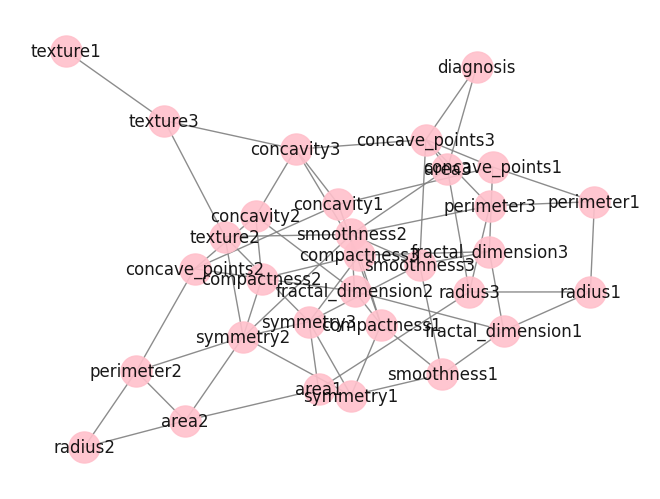

In [11]:
plot_graph(graph, nodes, label)

Currently, the graph are undirectly not using several rule to turn this graph into Completed Partially Directed Acyclic Graph (CPDAG)


**Rule No. 1**: $i \rightarrow j - k$    to    $i \rightarrow j \rightarrow k$

If there is a directed edge $i \rightarrow j$, and no edge between $i$ and $k$, then the undirected edge $j-k$ becomes directed edge $j \rightarrow k$

> The reason why it is not "k to j" is because this would create a collider.
>
> When blocking j, "i and k" become related.
>
> Since "i and k" are not linked, a collider should not exist.
>
> Thus, j to k is the only option.

**Rule No. 2**: $i \rightarrow j \rightarrow k - i$    to    $i \rightarrow j \rightarrow k \leftarrow i$

If there are directed edges $i \rightarrow j$ and $j \rightarrow k$, then the undirected edge $i - k$ becomes directed from $i \rightarrow k$.

> The reason why it is not "k to i" is because this would create a cyclic graph, which is not allowed in a DAG

**Rule No. 3**: $j \leftarrow k - i - l \rightarrow j - i$    to    $j \leftarrow k - i - l \rightarrow j \leftarrow i$

If there are undirected edges $i-k$ and $i-l$, and directed edges $k \rightarrow j$, $l \rightarrow j$, with $k$ and $l$ being nonadjacent, then the undirected edge $i - j$ becomes directed $i \rightarrow j$.

> If "j to i", then the only possible path between k and i will be "k to i" (i to k will form an cyclic graph) and for l and i, it will be "l to i" (same as k to i).
>
> And this creates a collider for i, k, and l again.
>
> Therefore, k and l should not be separated.

**Rule No. 4**: $i - k \rightarrow l \rightarrow j - i$    to    $i - k \rightarrow l \rightarrow j \rightarrow i$

If there is a node $k$ in the separation set of nonadjacent nodes $j$, and a directed edge $k \rightarrow l$, with an undirected edge $i-k$, and a directed edge from $l \rightarrow j$, then the undirected edge $i-j$ becomes directed $i \rightarrow j$.

> if "j to i", then i and k cannot be i to k, and k to i will form an collidar but k and j are not liked.

# WIP